In [1]:
# ------------------------------------------------------------------------------
#
#   Copyright 2024 Valory AG
#
#   Licensed under the Apache License, Version 2.0 (the "License");
#   you may not use this file except in compliance with the License.
#   You may obtain a copy of the License at
#
#       http://www.apache.org/licenses/LICENSE-2.0
#
#   Unless required by applicable law or agreed to in writing, software
#   distributed under the License is distributed on an "AS IS" BASIS,
#   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#   See the License for the specific language governing permissions and
#   limitations under the License.
#
# ------------------------------------------------------------------------------

"""Script to simulate markets."""

import math
import random
import ipympl
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


from collections import Counter
from typing import Any, Dict, List, Callable
from datetime import datetime, date, timedelta, timezone
from IPython.display import display, HTML
from mpl_toolkits.mplot3d import Axes3D
from omen_subgraph_utils import get_fpmms, get_market_state, MarketState
from scipy.stats import describe

# Enable matplotlib inline backend
%matplotlib widget

In [2]:
# Collect markets

collected_fpmms = get_fpmms("0x89c5cc945dd550BcFfb72Fe42BfF002429F46Fec")

             Fetching fpmms...


               Fetching trades: 100%|██████████| 3759/3759 [00:00<00:00, 489047.08it/s]


In [3]:
# Filter markets

def filter_fpmms(fpmms: Dict[str, Dict[str, Any]], condition: Callable[[Dict[str, Any]], bool]) -> Dict[str, Dict[str, Any]]:
    """Generic filter for fpmms based on a condition function."""
    return {key: market_data for key, market_data in fpmms.items() if condition(market_data)}

fpmms = collected_fpmms
print(f"Number of fpmms before filtering: {len(collected_fpmms)}")

state = MarketState.CLOSED
fpmms = filter_fpmms(fpmms, lambda m: get_market_state(m) == state)
print(f"Number of fpmms after filter by market state {state}: {len(fpmms)}")

fpmms = filter_fpmms(fpmms, lambda m: len(m.get("trades", [])) > 0)
print(f"Number of fpmms after filter markets with 0 trades: {len(fpmms)}")

Number of fpmms before filtering: 3759
Number of fpmms after filter by market state MarketState.CLOSED: 3484
Number of fpmms after filter markets with 0 trades: 3462


interactive(children=(SelectionRangeSlider(description='Dates', index=(0, 315), layout=Layout(width='700px'), …

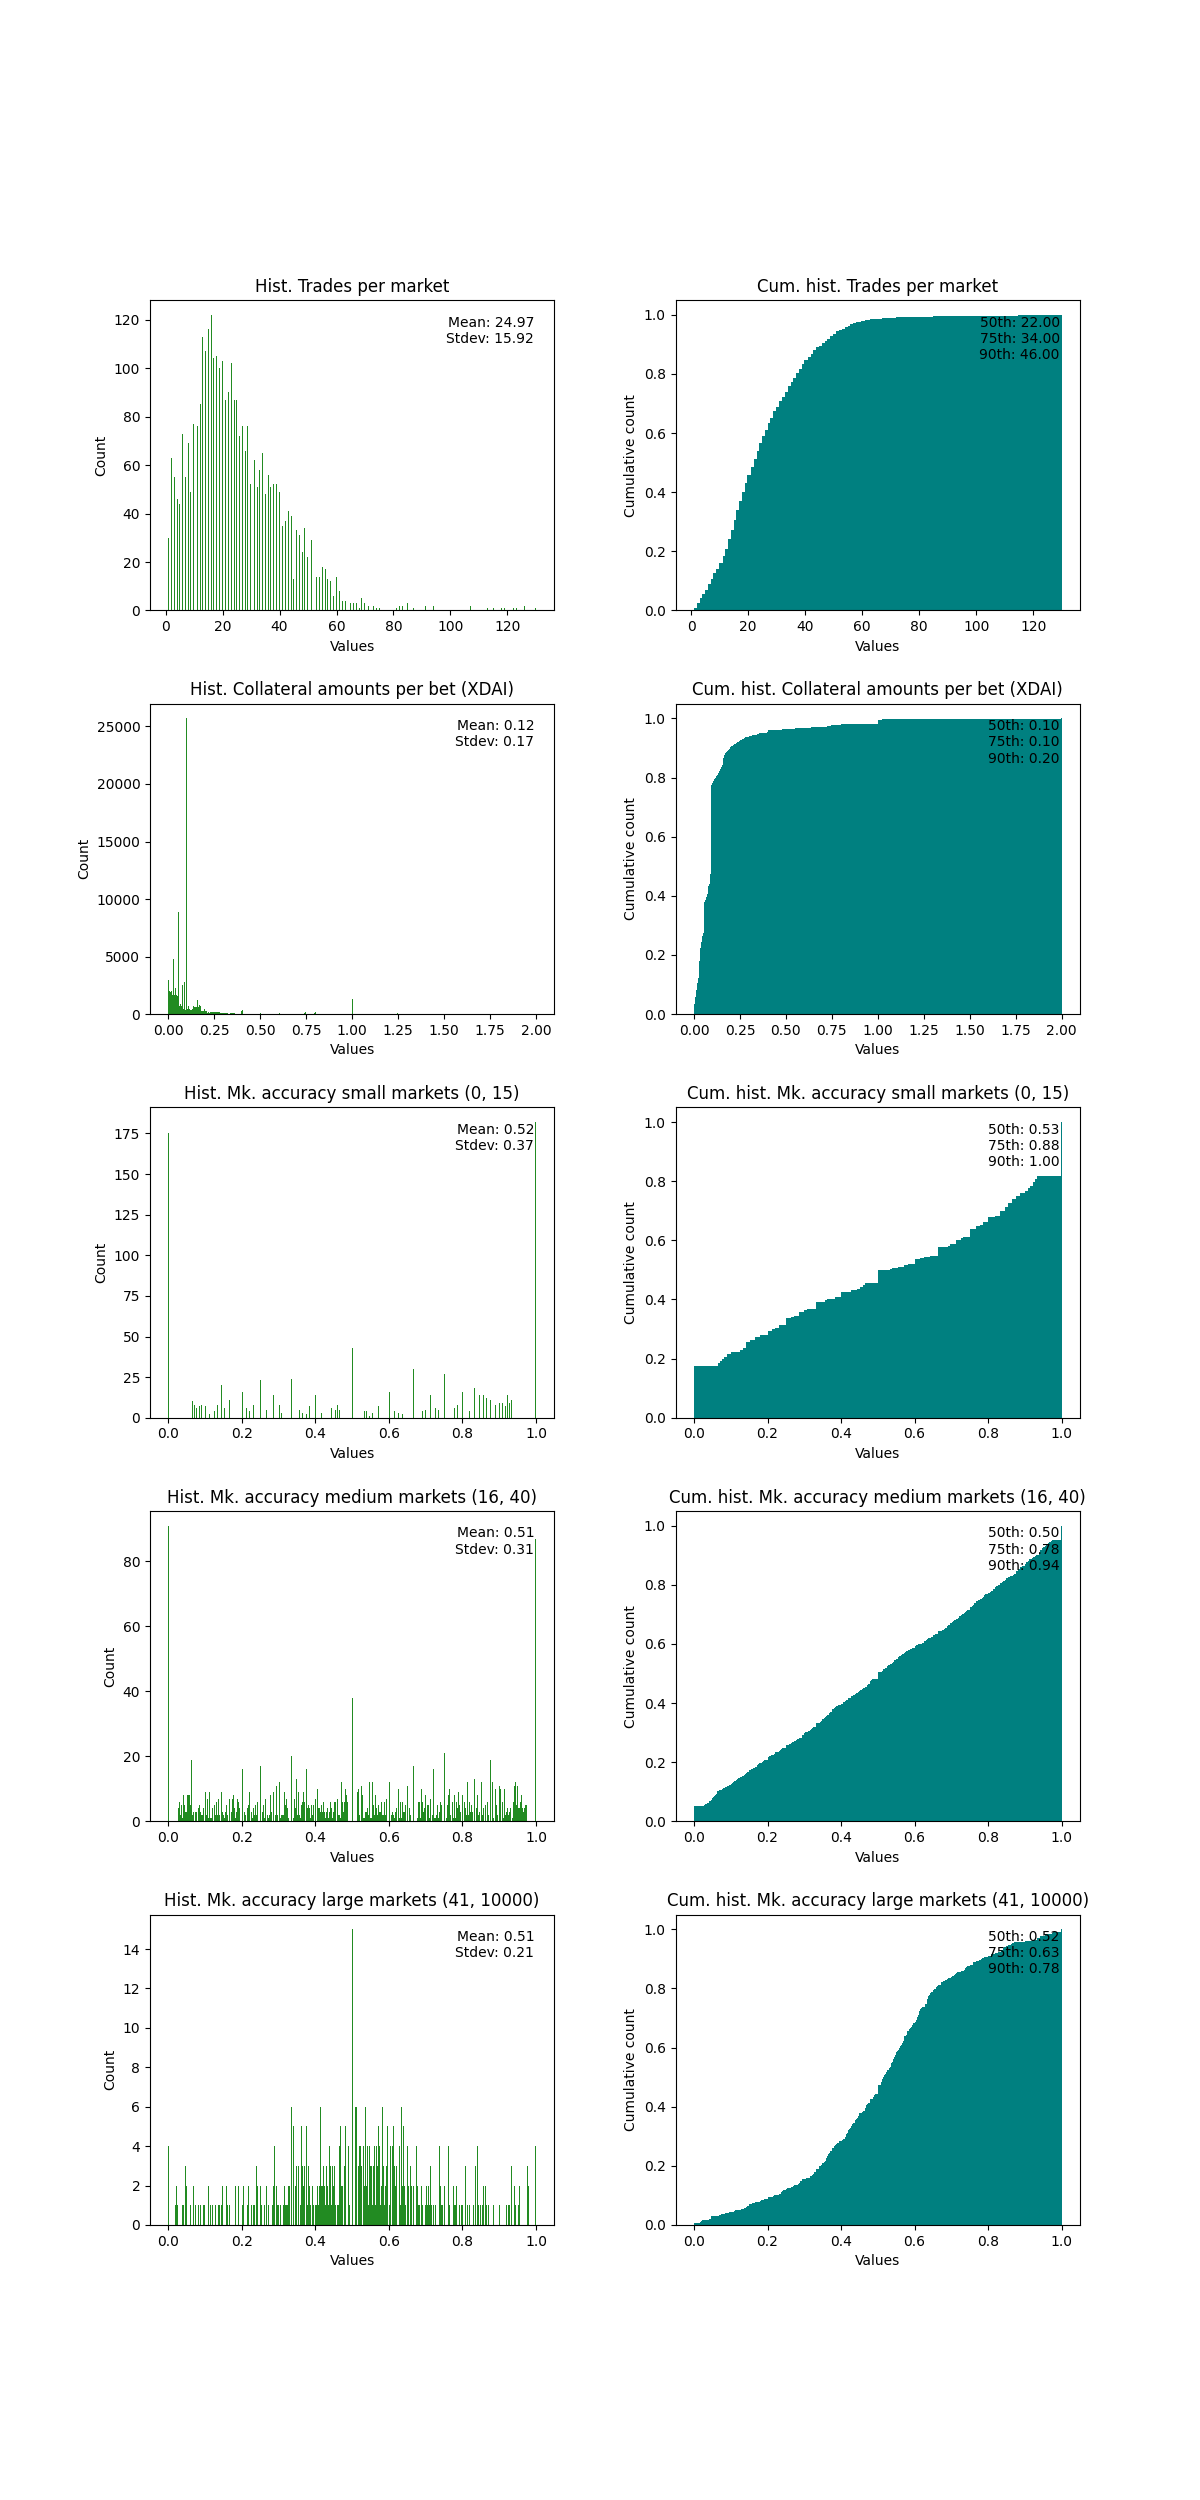

In [4]:
# Plot collected data

def plot_histogram(ax1, ax2, values: List[Any], title: str, n_bins: int = 400) -> None:
    """Plot histogram and cumulative histogram on provided axes."""
    summary = describe(values)
    mean = summary.mean
    stdev = np.sqrt(summary.variance)

    bin_size = (max(values) - min(values)) / n_bins 
    bins = np.arange(min(values), max(values) + bin_size, bin_size)

    # Clear the axes
    ax1.cla()
    ax2.cla()

    # Plot histogram
    ax1.hist(values, bins=bins, color='forestgreen')
    ax1.set_xlabel('Values')
    ax1.set_ylabel('Count')
    ax1.set_title(f'Hist. {title}')
    ax1.text(0.95, 0.95, f'Mean: {mean:.2f}\nStdev: {stdev:.2f}', 
             transform=ax1.transAxes, fontsize=10, verticalalignment='top', horizontalalignment='right')

    # Plot cumulative histogram
    percentiles = np.percentile(values, [50, 75, 90])
    ax2.hist(values, bins=bins, color='teal', density=True, cumulative=True)
    ax2.set_xlabel('Values')
    ax2.set_ylabel('Cumulative count')
    ax2.set_title(f'Cum. hist. {title}')
    ax2.text(0.95, 0.95, f'50th: {percentiles[0]:.2f}\n75th: {percentiles[1]:.2f}\n90th: {percentiles[2]:.2f}', 
             transform=ax2.transAxes, fontsize=10, verticalalignment='top', horizontalalignment='right')


def create_subplot_grid(num_histograms: int) -> Any:
    """Create a grid of subplots for the number of histograms."""
    fig, axs = plt.subplots(num_histograms, 2, figsize=(12, 5 * num_histograms))
    fig.subplots_adjust(wspace=0.3, hspace=0.3)
    if num_histograms == 1:
        axs = [axs]
    return fig, axs


def convert_answer(answer: str) -> int:
    if answer == "0x0000000000000000000000000000000000000000000000000000000000000001":
        return 1
    elif answer == "0x0000000000000000000000000000000000000000000000000000000000000000":
        return 0
    else:
        return -1


# Market accuracy array
def get_market_accuracy(fpmms: Dict[str, Dict[str, Any]]) -> List[float]:
    accuracy = []
    for market_data in fpmms.values():
        market_answer = convert_answer(market_data.get("currentAnswer"))
        if market_answer == -1:
            continue

        trades = market_data.get("trades", {})
        total_trades = len(trades)

        if total_trades == 0:
            continue

        matching_trades = 0

        for trade in trades.values():
            trade_outcome_index = int(trade["outcomeIndex"])
            if trade_outcome_index == market_answer:
                matching_trades += 1

        accuracy.append(matching_trades / total_trades)
    
    return accuracy


small_markets = (0, 15)
medium_markets = (16, 40)
large_markets = (41, 10000)

def update_histograms(date_range):
    start_date, end_date = date_range
    from_timestamp = start_date.timestamp()
    to_timestamp = end_date.timestamp()
    filtered_fpmms = filter_fpmms(
        fpmms=fpmms,
        condition=lambda m: from_timestamp <= int(m.get("creationTimestamp", 0)) <= to_timestamp
        )

    # Trades per market
    trades_per_market = [len(market_data.get('trades', {})) for market_data in filtered_fpmms.values()]
    ax1, ax2 = axs[0]
    plot_histogram(ax1, ax2, trades_per_market, "Trades per market")

    # Collateral amounts invested
    collateral_amounts = []
    for market_data in filtered_fpmms.values():
        trades = market_data.get("trades", {})
        for trade_data in trades.values():
            collateral_amounts.append(float(trade_data["collateralAmount"])/1e18)

    limit = 2.0
    collateral_amounts = [x for x in collateral_amounts if x <= limit]
    ax1, ax2 = axs[1]
    plot_histogram(ax1, ax2, collateral_amounts, "Collateral amounts per bet (XDAI)")

    # Market accuracy
    filtered_small_fpmms = filter_fpmms(filtered_fpmms, lambda m: len(m.get('trades', {})) <= small_markets[1])
    accuracy = get_market_accuracy(filtered_small_fpmms)  
    ax1, ax2 = axs[2]
    plot_histogram(ax1, ax2, accuracy, f"Mk. accuracy small markets {small_markets}")

    filtered_medium_fpmms = filter_fpmms(filtered_fpmms, lambda m: medium_markets[0] <= len(m.get('trades', {})) <= medium_markets[1])
    accuracy = get_market_accuracy(filtered_medium_fpmms)  
    ax1, ax2 = axs[3]
    plot_histogram(ax1, ax2, accuracy, f"Mk. accuracy medium markets {medium_markets}")

    filtered_large_fpmms = filter_fpmms(filtered_fpmms, lambda m: large_markets[0] <= len(m.get('trades', {})))
    accuracy = get_market_accuracy(filtered_large_fpmms)  
    ax1, ax2 = axs[4]
    plot_histogram(ax1, ax2, accuracy, f"Mk. accuracy large markets {large_markets}")

    fig.canvas.draw_idle()


# Initialize the figure and axes
num_histograms = 5
fig, axs = create_subplot_grid(num_histograms)

# Dates slider
min_creation_timestamp = int(datetime.now(timezone.utc).timestamp())

for market_data in fpmms.values():
    creation_timestamp = int(market_data['creationTimestamp'])
    if creation_timestamp < min_creation_timestamp:
        min_creation_timestamp = creation_timestamp

start_date = datetime.fromtimestamp(min_creation_timestamp, tz=timezone.utc)
end_date = datetime.now(timezone.utc)

dates = pd.date_range(start_date, end_date, freq='D')
options = [(date.strftime(' %d %b %Y '), date) for date in dates]
index = (0, len(options)-1)

selection_range_slider = widgets.SelectionRangeSlider(
    options=options,
    index=index,
    description='Dates',
    orientation='horizontal',
    layout={'width' : '700px'},
)

# Interactive plot
plt.ion()
interactive_widget = widgets.interactive(update_histograms, date_range=selection_range_slider)
display(interactive_widget)


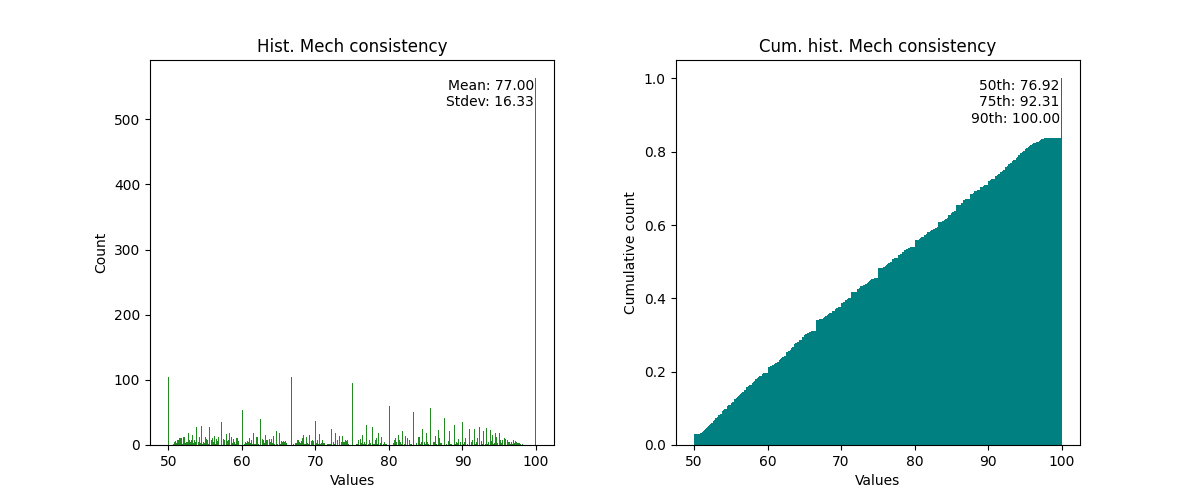

In [5]:
# Mech consistency
consistency = []
for market_data in fpmms.values():
    trades = market_data.get("trades", {})
    
    if trades:
        outcome_index_counts = Counter(trade_data["outcomeIndex"] for trade_data in trades.values())
        majority_outcome_index, majority_count = max(outcome_index_counts.items(), key=lambda x: x[1])
        consistency_percentage = (majority_count / len(trades)) * 100
        consistency.append(consistency_percentage)

fig, axs = create_subplot_grid(1)
plot_histogram(axs[0][0], axs[0][1], consistency, "Mech consistency")

In [6]:
# Market simulation functions

def fpmm_trade(amount: float, option: int, L0: float, L1: float, market_fee: float=0.02, mech_cost: float=0.01, mech_calls_per_trade: int=1) -> (int, int, int):
    """Simulates an fpmm trade with liquidity L0 and L1 for options 1 and 2, respectively."""
    # Outputs: (new liquidity L0, new liquidity L1, outcome tokens received 0, outcome tokens received 1, unused amount)

    k = L0*L1
    bet_amount = (amount - mech_cost*mech_calls_per_trade)*(1-market_fee)

    if bet_amount <= 0:
        return (L0, L1, 0, 0, amount)

    if option == 0:
        return (L0+bet_amount, (L0*L1/(L0+bet_amount)), bet_amount + L1-(k/(L0+bet_amount)), 0, 0)
    else:
        return ((L0*L1/(L1+bet_amount)), L1+bet_amount, 0, bet_amount + L0-(k/(L1+bet_amount)), 0)


def fpmm_trade_all(trades: List[Any], L0: float, L1: float, market_fee: float=0.02, mech_cost: float=0.01, mech_calls_per_trade: int=1, win_option: int=0) -> (float, float):
    """Executes a cycle of trades on an fpmm."""
    final_amounts = []
    for amount, option in trades:
        (L0, L1, rcv0, rcv1, unused_amount) = fpmm_trade(
            amount=amount,
            option=option,
            L0=L0,
            L1=L1,
            market_fee=market_fee,
            mech_cost=mech_cost,
            mech_calls_per_trade=mech_calls_per_trade)

        if win_option == 0:
            final_amounts.append(rcv0+unused_amount)
        else:
            final_amounts.append(rcv1+unused_amount)
        #print(f"{opt=}  {win_option=}")
        #print(L0, L1, rcv, L0*L1)
    return (L0, L1, final_amounts)


def simulate(nTrades0: int, nTrades1: int, amount: float, L0: float, L1: float, market_fee: float=0.02, mech_cost: float=0.01, mech_calls_per_trade: int=1, win_option: int=0, iterations: int=1) -> Any:
    """Simulates an fpmm."""
    p0_total = 0.0
    total_final_amount = 0.0
    total_initial_amount = (nTrades0 + nTrades1) * amount * iterations
    
    trades0 = [(amount,0)]*nTrades0
    trades1 = [(amount,1)]*nTrades1
    trades = trades0 + trades1

    for _ in range(iterations):
        random.shuffle(trades)
        (L0_result, L1_result, final_amounts) = fpmm_trade_all(
            trades=trades,
            L0=L0,
            L1=L1,
            market_fee=market_fee,
            mech_cost=mech_cost,
            mech_calls_per_trade=mech_calls_per_trade,
            win_option=win_option)

        # The market probability of an option is proportional to its liquidity
        probability = L0_result / (L0_result + L1_result)
        p0_total += probability
        #print(earnings)
        total_final_amount += sum(final_amounts)

    avg_probability = p0_total / iterations

    if nTrades0 + nTrades1 > 0:
        avg_roi = (total_final_amount - total_initial_amount) / total_initial_amount
    else:
        avg_roi = 0

    return np.array([avg_probability, avg_roi])


def tests() -> None:
    # Test trade all
    trades = [(1.,0), (1.,0), (0.8,0), (0.8,0), (0.8,0), (0.32,0)]
    L0 = L1 = 10
    (L0, L1, earnings) = fpmm_trade_all(trades, L0, L1, 0.02, 0)
    p = L0/(L0+L1)
    expected_value = 0.6814355029609638
    tolerance = 1e-6
    assert abs(expected_value - p) < tolerance, "Market simulation does not match expected result."
    
    # Test simulations
    assert abs(simulate(4, 0, 1.0, 10, 10, 0.02, 0, 1, 0, 1)[1] - 0.6840229885057476) < tolerance, "Market simulation does not match expected result: 4 win trades"
    assert simulate(0, 4, 1.0, 10, 10, 0.02, 2, 1, 0, 1)[1] == 0, "Market simulation does not match expected result: ROI for mech costs > available amount != 0. "
    assert simulate(0, 4, 1.0, 10, 10, 0.02, 0, 1, 0, 1)[1] == -1, "Market simulation does not match expected result: ROI for all trades lose != -1."


tests()

interactive(children=(IntSlider(value=50, description='nTrades', layout=Layout(width='400px'), max=200), Float…

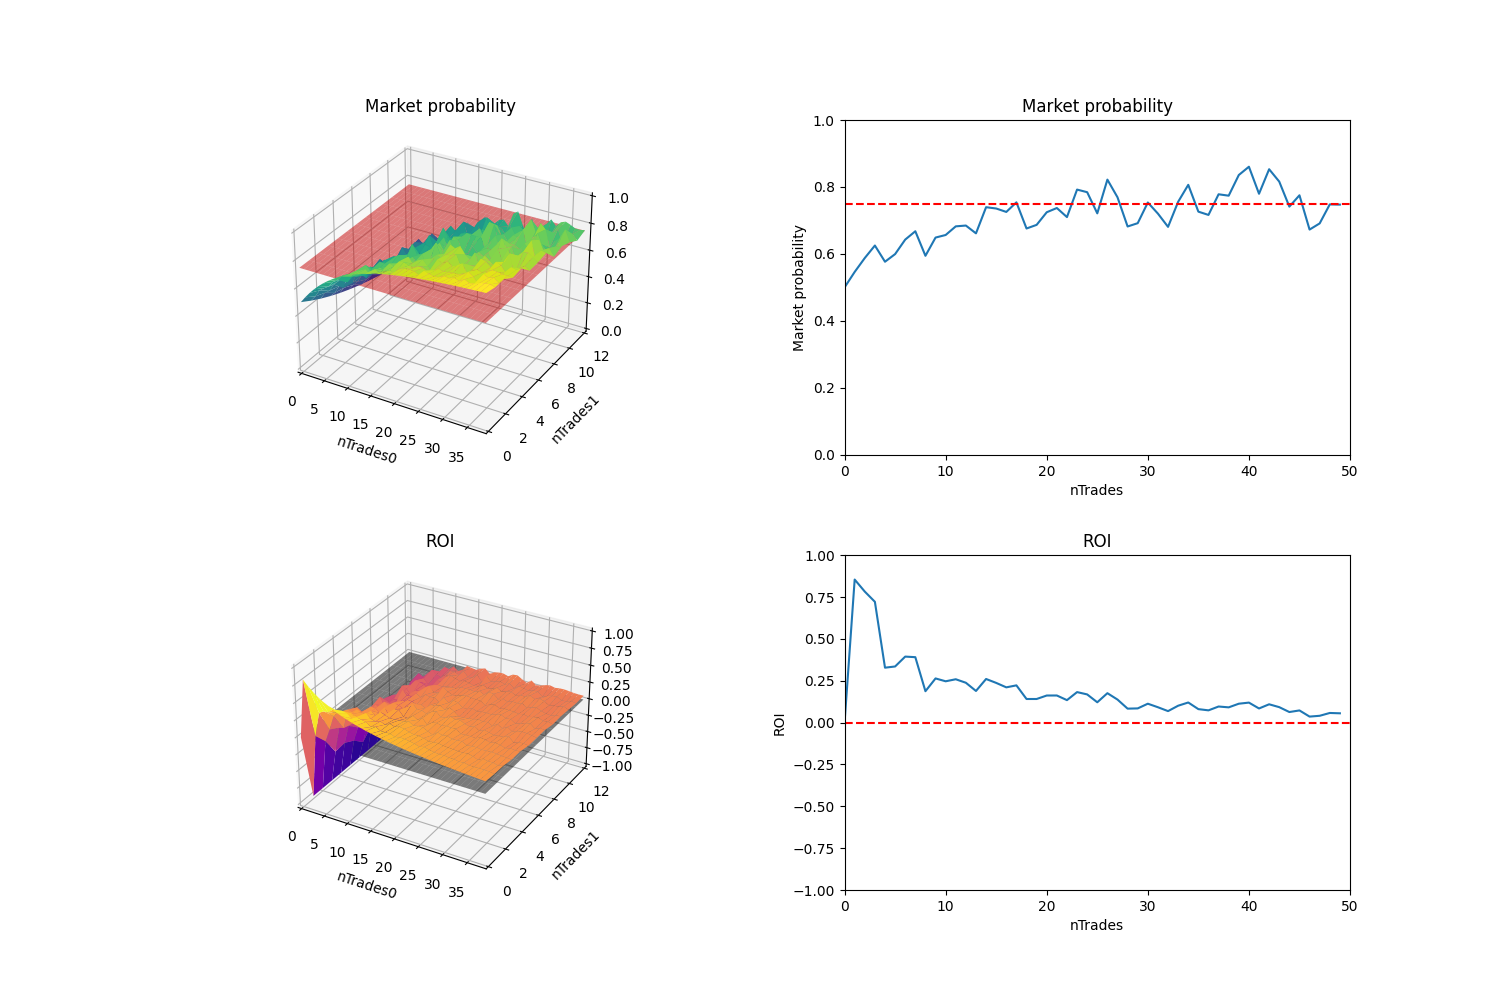

In [8]:
# Plot simulations

def update_plot(nTrades: int, mech_consistency: float, amount: float, liquidity: float, market_fee: float, mech_cost: float, mech_calls_per_trade: int, iterations: int):
    global results, surf1, surf3, surf_plane1, surf_plane3
    
    win_option = 0
    L0 = liquidity
    L1 = liquidity
    
    nTrades0 = math.ceil(nTrades * mech_consistency)
    nTrades1 = nTrades - nTrades0
    
    nTrades0_range = np.arange(nTrades0 + 1)
    nTrades1_range = np.arange(nTrades1 + 1)
    nTrades0_values, nTrades1_values = np.meshgrid(nTrades0_range, nTrades1_range)
    
    Z0 = np.zeros_like(nTrades0_values, dtype=float)
    Z1 = np.zeros_like(nTrades1_values, dtype=float)

    # Iterate over the meshgrid arrays
    for i in range(nTrades0_values.shape[0]):
        for j in range(nTrades0_values.shape[1]):
            result1, result2 = simulate(
                nTrades0=int(nTrades0_values[i, j]),
                nTrades1=int(nTrades1_values[i, j]),
                amount=amount,
                L0=L0,
                L1=L1,
                market_fee=market_fee,
                mech_cost=mech_cost,
                mech_calls_per_trade=mech_calls_per_trade,
                win_option=win_option,
                iterations=iterations
            )
            Z0[i, j] = result1
            Z1[i, j] = result2
    
    avg_probabilities = Z0
    avg_rois = Z1

    # Plot 3D market probability
    if surf1 is not None:
        surf1.remove()
    surf1 = ax1.plot_surface(nTrades0_values, nTrades1_values, avg_probabilities, cmap='viridis')
    ax1.set_xlim(0, nTrades0)
    ax1.set_ylim(0, nTrades1)
    ax1.set_zlim(0, 1)
    
    if surf_plane1 is not None:
        surf_plane1.remove()
    surf_plane1 = ax1.plot_surface(nTrades0_values, nTrades1_values, np.full_like(avg_probabilities, mech_consistency), color='red', alpha=0.5)
    
    # Plot diagonal market probability
    results2 = np.array([avg_probabilities[t - math.ceil(t * mech_consistency), math.ceil(t * mech_consistency)] for t in range(nTrades)])
    ax2.clear()
    ax2.set_xlabel('nTrades')
    ax2.set_ylabel('Market probability')
    ax2.set_title('Market probability')
    ax2.plot(results2)
    ax2.axhline(y=mech_consistency, color='red', linestyle='--')
    ax2.set_xlim(0, nTrades)
    ax2.set_ylim(0, 1)

    # Plot 3D ROI
    if surf3 is not None:
        surf3.remove()
    surf3 = ax3.plot_surface(nTrades0_values, nTrades1_values, avg_rois, cmap='plasma')
    ax3.set_xlim(0, nTrades0)
    ax3.set_ylim(0, nTrades1)
    ax3.set_zlim(-1, 1)

    if surf_plane3 is not None:
        surf_plane3.remove()
    surf_plane3 = ax3.plot_surface(nTrades0_values, nTrades1_values, np.full_like(avg_rois, 0), color='black', alpha=0.5)


    # Plot diagonal ROI
    results4 = np.array([avg_rois[t - math.ceil(t * mech_consistency), math.ceil(t * mech_consistency)] for t in range(nTrades)])
    ax4.clear()
    ax4.set_xlabel('nTrades')
    ax4.set_ylabel('ROI')
    ax4.set_title('ROI')
    ax4.plot(results4)
    ax4.axhline(y=0, color='red', linestyle='--')
    ax4.set_xlim(0, nTrades)
    ax4.set_ylim(-1, 1)



# Create the figure and subplots
plt.ion()
fig = plt.figure(figsize=(15, 10))
fig.subplots_adjust(wspace=0.3, hspace=0.3)
ax1 = fig.add_subplot(221, projection='3d')
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223, projection='3d')
ax4 = fig.add_subplot(224)
surf1 = None
surf3 = None
surf_plane1 = None
surf_plane3 = None
ax1.set_xlabel('nTrades0')
ax1.set_ylabel('nTrades1')
ax1.set_title('Market probability')
ax3.set_xlabel('nTrades0')
ax3.set_ylabel('nTrades1')
ax3.set_title('ROI')

# Create interactive plot
slider_layout = widgets.Layout(width='400px')
nTrades_slider = widgets.IntSlider(value=50, min=0, max=200, step=1, description='nTrades', layout=slider_layout)
mech_consistency_slider = widgets.FloatSlider(value=0.75, min=0, max=1, step=0.01, description='Mech consistency', layout=slider_layout)
amount_slider = widgets.FloatSlider(value=1, min=0, max=10, step=0.01, description='Bet amount', layout=slider_layout)
liquidity_slider = widgets.FloatSlider(value=10, min=0, max=20, step=0.1, description='Liquidity', layout=slider_layout)
market_fee_slider = widgets.FloatSlider(value=0.02, min=0, max=1, step=0.01, description='Market fee', layout=slider_layout)
mech_cost_slider = widgets.FloatSlider(value=0.01, min=0, max=1, step=0.01, description='Mech cost', layout=slider_layout)
mech_calls_per_trade_slider = widgets.IntSlider(value=1, min=0, max=10, step=1, description='Mech calls per trade', layout=slider_layout)
iterations_slider = widgets.IntSlider(value=1, min=1, max=50, step=1, description='Iterations', layout=slider_layout)
widgets.interactive(update_plot, liquidity=liquidity_slider, amount=amount_slider, nTrades=nTrades_slider, mech_consistency=mech_consistency_slider, market_fee=market_fee_slider, mech_cost=mech_cost_slider, mech_calls_per_trade=mech_calls_per_trade_slider, iterations=iterations_slider)


Definitions:
- Market probability: Liquidity of the most voted option over the total liquidity. Ideally it should match the "population's belief" based on the trades.
- Market accuracy: The accuracy of the market in predicting the ground truth once resolved.
- Mech consistency: Percentage of the most voted option provided by the mech. This is the "population's belief".

Some observations:

- The market probability reflects what the traders think, which may or may not coincide with the actual result of the market once it is resolved. 
- The mech is abstracted as the collection of all the tools to which the traders interact.
- Asymptotically, i.e., with a large enough number of trades and large enough bet amounts, the market probability tends to the mech consistency. This is the best result we can hope for, since the market has no way to know "the ground truth" until it is resolved.
- This process can be "speed up" by either increasing the number of trades in the market, or by increasing the amount per trade, relative to the market liquidity.
- The simulation above does not distinguish between options (the problem is symmetrical). By default, it is considered that the winner option is 0.

Proposed values:
- nTrades = 50
- Mech consistency = 0.75
- Bet amount = 0.40 XDAI
- Market liquidity = 7.00 XDAI
- Market fee= 2%
- Mech cost = 0.01 XDAI
- Mech calls = 4 (at 5 it produces negative average ROI)